In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.data.metrics import bleu_score

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tqdm.auto import tqdm

In [ ]:
input_data = pd.read_csv('/content/data_f.txt', sep='\n', names=['Input'])

output_data = pd.read_csv('/content/label_f.txt', sep='\n', names=['Output'])

In [ ]:
#input_data['Input'][0]
#output_data['Output'][0]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
input_dataset = []
output_dataset = []

for row in input_data['Input']:
    input_dataset.append(row)

for row in output_data['Output']:
    output_dataset.append(row)

In [ ]:
print(len(input_dataset))
print(len(output_dataset))

31383
31383


In [ ]:
input_dataset[:5]

[' Now, beautiful Hippolyta , the hour of our wedding is speeding closer.In four joyful days there will be a new crescent moon, and we will marry.But oh!The old moon seems to me to shrink away so slowly!',
 ' Four days will quickly pass and turn to night.And each night, we will dream away the time.And soon the moon   like a silver bow newly bent into a curve in the sky  will look down on the night of our wedding celebration.',
 ' Go, Philostrate, get the young people of Athens in the mood to celebrate.Wake up the lively and swift spirit of fun.Send sadness out to funerals  that pale emotion has no place at our festivities.PHILOSTRATE exits.',
 ' Joy to you, Theseus  our famous and distinguished duke!',
 ' Thank you, dear Egeus.What’s going on with you?']

In [ ]:
output_dataset[:5]

[' Now, fair Hippolyta, our nuptial hour Draws on apace.Four happy days bring in Another moon.But oh, methinks how slow This old moon wanes!She lingers my desires, Like to a stepdame or a dowager Long withering out a young man’s revenue.',
 ' Four days will quickly steep themselves in night.Four nights will quickly dream away the time.And then the moon, like to a silver bow New bent in heaven, shall behold the night Of our solemnities.',
 ' Go, Philostrate, Stir up the Athenian youth to merriments.Awake the pert and nimble spirit of mirth.Turn melancholy forth to funerals.The pale companion is not for our pomp.',
 ' Happy be Theseus, our renownèd duke.',
 ' Thanks, good Egeus.What’s the news with thee?']

In [ ]:
class ShakespeareDataset(Dataset):

    def __init__(self, input_encodings, output_encodings):
        self.input_encodings = input_encodings
        self.output_encodings = output_encodings
        #self.max_length = max(len(self.input_encodings['input_ids']) , len(self.output_encodings['input_ids']))

    def __getitem__(self, index):
        
        x = {key: torch.tensor(val[index]) for key,val in self.input_encodings.items()}
        y = {key: torch.tensor(val[index]) for key,val in self.output_encodings.items()}
        return x,y

    def __len__(self):
        return len(self.input_encodings['input_ids'])

In [ ]:
train_dataset = ShakespeareDataset(tokenizer(input_dataset[:5000], truncation=True, padding=True) , tokenizer(output_dataset[:5000], truncation=True, padding=True))
val_dataset = ShakespeareDataset(tokenizer(input_dataset[5000:6000], truncation=True, padding=True) , tokenizer(output_dataset[5000:6000], truncation=True, padding=True))


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
len(val_dataloader)

125

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
for i in train_dataloader:
    print(i)
    break

[{'input_ids': tensor([[19134,    11, 10846,  ..., 50256, 50256, 50256],
        [ 2094,   470, 10072,  ..., 50256, 50256, 50256],
        [  679, 12165,   379,  ..., 50256, 50256, 50256],
        ...,
        [ 1649,   257,   582,  ..., 50256, 50256, 50256],
        [ 7731,   345,   766,  ..., 50256, 50256, 50256],
        [24088,    11,   314,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[  921,   821,  7062,  ..., 50256, 50256, 50256],
        [  569,  1069,   407,  ..., 50256, 50256, 50256],
        [ 3954, 15106,  4487,  ..., 50256, 50256, 50256],
        ...,
        [ 1649,   257,   582,  ..., 50256, 50256, 50256],
        [ 7731,   301, 14210,  ..., 50256, 50256, 50256],
        [24088,    11,   314,  ..., 50256, 50256, 50256]]), 'attent

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(device)

In [ ]:
epochs = 10
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(epochs):

    print(f"Epoch {epoch}")

    train_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        
        x,y = batch
        input_ids = x['input_ids'].to(device)
        attention_mask = x['attention_mask'].to(device)
        labels= y['input_ids'].to(device)
        #print(labels.shape)
        #print(batch)
        labels = labels[:,:input_ids.shape[-1]]
        outputs = model(input_ids=input_ids, labels=labels)
        #outputs = model(x['input_ids'],y['input_ids'])
        loss = outputs.loss

        train_loss += loss
        train_loss = train_loss.detach()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print("Training Loss =",train_loss)

    train_loss_epochs.append(train_loss.cpu()/len(train_dataloader))



    val_loss = 0

    model.eval()
    for batch in tqdm(val_dataloader):

        x,y = batch
        input_ids = x['input_ids'].to(device)
        attention_mask = x['attention_mask'].to(device)
        labels= y['input_ids'].to(device)
        #print(labels.shape)
        #print(batch)
        labels = labels[:,:input_ids.shape[-1]]
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels)
            #outputs = model(x['input_ids'],y['input_ids'])
            val_loss += outputs.loss
        
    print("Validation Loss =",val_loss)

    val_loss_epochs.append(val_loss.cpu()/len(val_dataloader))

Epoch 0


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(387.7469, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(96.6363, device='cuda:0')
Epoch 1


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(339.2532, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(96.2856, device='cuda:0')
Epoch 2


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(333.8468, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(93.8930, device='cuda:0')
Epoch 3


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(329.4062, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(93.8630, device='cuda:0')
Epoch 4


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(325.7137, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(93.5600, device='cuda:0')
Epoch 5


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(321.7253, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(92.9594, device='cuda:0')
Epoch 6


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(317.5063, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(93.1377, device='cuda:0')
Epoch 7


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(311.0627, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(95.6173, device='cuda:0')
Epoch 8


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(306.1291, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(93.8648, device='cuda:0')
Epoch 9


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(301.0074, device='cuda:0')


  0%|          | 0/125 [00:00<?, ?it/s]

Validation Loss = tensor(96.4436, device='cuda:0')


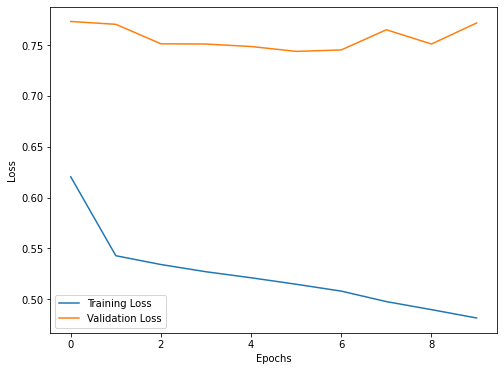

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(epochs) , train_loss_epochs, label='Training Loss');
plt.plot(torch.arange(epochs) , val_loss_epochs, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();

In [ ]:
input = tokenizer.encode('Why do you look so sad?')
input

[5195, 466, 345, 804, 523, 6507, 30]

In [ ]:
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=20, do_sample=True, temperature=0.9)

In [ ]:
tokenizer.decode(output[0])

'Why do you look so sad?<|endoftext|>'

In [ ]:
tokenizer.decode(torch.argmax(model(torch.tensor(input).to(device)).logits, dim=1))

', how you?<|endoftext|>'

In [ ]:
tokenizer.decode(torch.argmax(model(torch.tensor(input)).logits, dim=1))

In [ ]:
torch.save(model.state_dict(), '/content/gpt2_training_1.pt')